In [1]:
pip install gym torch numpy matplotlib



     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------- --------------------------- 204.8/721.7 kB 6.3 MB/s eta 0:00:01
     --------------------------------- ---- 634.9/721.7 kB 6.7 MB/s eta 0:00:01
     -------------------------------------  716.8/721.7 kB 6.5 MB/s eta 0:00:01
     -------------------------------------- 721.7/721.7 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827629 sha256=06b423e85d5e780aac335e68d6a7bd6c815b0495596690961947ffc8bbeb1ee0
  Stored in directory: c:\users\shrey\appdata\local\pip\cache\wheels\1c\77\9e\9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
S

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

## Defining Policy Network

In [63]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.leaky_relu(self.fc_1(x))
        x = self.dropout(x)              
        x = self.fc_2(x)                   
        return x  

## Reinforcement Algorithm

In [64]:
class ReinforceAgent:
    def __init__(self, env, pol_network, lr=1e-2):
        self.env = env
        self.pol_network = pol_network
        self.opt = optim.Adam(pol_network.parameters(), lr=lr)
        self.rewards = []
        self.log_probs = []

    def select_act(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  
        logits = self.pol_network(state)  
        probab = torch.softmax(logits, dim=-1)  
        act_distri = torch.distributions.Categorical(probab) 
        action = act_distri.sample()
        return action.item(), act_distri.log_prob(action) 

    def store_rew(self, reward):
        self.rewards.append(reward)

    def update_pol(self, gamma=0.99, use_baseline=True):
        R = 0
        dis_rewards = []
        
        # Calculating discounted rewards
        for r in reversed(self.rewards):
            R = r + gamma * R
            dis_rewards.insert(0, R)

        # Normalizing the discounted rewards
        dis_rewards = torch.tensor(dis_rewards, dtype=torch.float32)
        if use_baseline:
            baseline = dis_rewards.mean()
            dis_rewards = dis_rewards - baseline
        dis_rewards = (dis_rewards - dis_rewards.mean()) / (dis_rewards.std() + 1e-9)

        # Calculating policy loss
        pol_loss = []
        for log_prob, reward in zip(self.log_probs, dis_rewards):
            pol_loss.append(-log_prob * reward)
        entropy = -torch.sum(torch.exp(torch.stack(self.log_probs)) * torch.stack(self.log_probs))
        pol_loss = torch.stack(pol_loss).sum() - 0.01 * entropy 

        # Optimizing the policy
        self.opt.zero_grad()
        pol_loss.backward()
        self.opt.step()

        self.rewards.clear()
        self.log_probs.clear()

## Training

Episode 0, Reward: 13.0
Episode 50, Reward: 162.0
Episode 100, Reward: 82.0
Episode 150, Reward: 129.0
Episode 200, Reward: 61.0
Episode 250, Reward: 500.0
Episode 300, Reward: 500.0
Episode 350, Reward: 500.0
Episode 400, Reward: 500.0
Episode 450, Reward: 500.0


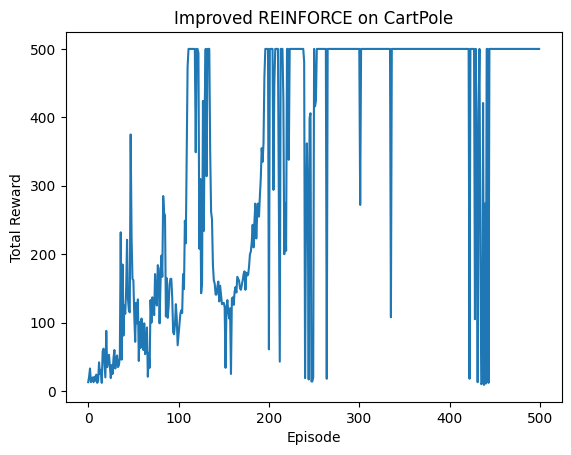

In [48]:
def train(agent, num_episodes=500):
    scores = []
    for episode in range(num_episodes):
        state = agent.env.reset()[0] 
        agent.rewards = []
        agent.log_probs = []
        epi_reward = 0
        
        while True:
            action, log_prob = agent.select_act(state)
            step_result = agent.env.step(action)

            if len(step_result) == 5: 
                nxt_state, reward, done, truncated, _ = step_result
                done = done or truncated 
            else:  
                nxt_state, reward, done, _ = step_result

            agent.log_probs.append(log_prob)
            agent.store_rew(reward)
            epi_reward += reward

            if done:
                break

            state = nxt_state  
        
        # Updating the policy after each episode
        agent.update_pol()
        scores.append(epi_reward)
        if episode % 50 == 0:
            print(f"Episode {episode}, Reward: {epi_reward}")

    return scores

# CartPole environment
env = gym.make("CartPole-v1")
input_dim = env.observation_space.shape[0]
hidden_dim = 128
output_dim = env.action_space.n
policy_net = PolicyNetwork(input_dim, hidden_dim, output_dim)
agent = ReinforceAgent(env, policy_net)

# Plotting results
scores = train(agent)

plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Improved REINFORCE on CartPole')
plt.show()
